In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
import glob
# import pickle
import pylab as plt

from matplotlib.pyplot import get_cmap
%matplotlib inline  

src_dir = os.path.abspath(os.path.join(os.pardir,'src'))
sys.path[0] = src_dir



In [2]:
from scipy.stats import skewnorm
from scipy.stats import skew
from scipy.stats import norm

# Data as generated by Katahira etal

In [3]:
## generate the data

## size of data
N = 145388 ## this is the number of samples in the IPIP300 data
# N = 10000

## parameter settings of the skew normals
xi = -1.
omega = 1.
alpha = 4.
# rotation
theta = np.pi/4

## generate data from 2 independent skewnormals with alpha and -alpha as skew-parameter
x1 = skewnorm.rvs(alpha,loc=xi,scale=omega,  size=N)
x2 = skewnorm.rvs(-alpha,loc=xi,scale=omega,  size=N)

## optional - z-scoring.
## I am not completely sure they do this in the analysis
x1 = (x1-np.mean(x1))/np.std(x1)
x2 = (x2-np.mean(x2))/np.std(x2)

X = np.zeros((N,2))
X[:,0] = x1
X[:,1] = x2

R = np.zeros((2,2))
R[0,0] = np.cos(theta)
R[0,1] = -np.sin(theta)
R[1,0] = np.sin(theta)
R[1,1] = np.cos(theta)
X = np.dot(X,R)

(-5, 5)

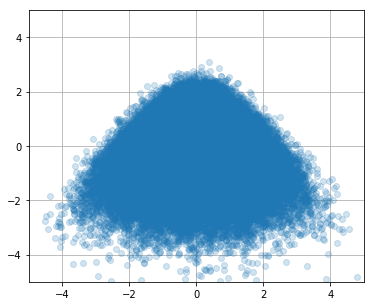

In [4]:
## 2D scatter
plt.figure(figsize=(6,5))
plt.plot(X[:,0],X[:,1],lw=0,marker='o',alpha=0.2)
plt.grid()
xlim = 5
ylim = 5
plt.xlim(-xlim,xlim)
plt.ylim(-ylim,ylim)

## Fitting a GMM

In the previous notebook, I confirmed that Nc=7 is the optimum number of clusters according to the BIC

In [5]:
from sklearn.mixture import GaussianMixture


In [6]:
Nc = 7
n_rep = 10
gmm = GaussianMixture(Nc,n_init=n_rep)
gmm.fit(X)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=10, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [7]:
## sample data from fitted GMM
X_gmm,labels_gmm = gmm.sample(n_samples=N)

# Compare densities from the two datasets

In [8]:
from sklearn.neighbors import KernelDensity

In [52]:
xlim, ylim = 4,4
nx,ny = 50,50
arr_x = np.linspace(-xlim,xlim,nx)
arr_y = np.linspace(-ylim,ylim,ny)

bw = 0.2

In [53]:
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(X)

## this is faster
## evaluating density for all values at once and then reshaping
list_z = []
for i_y,y in enumerate(arr_y):
    for i_x,x in enumerate(arr_x):
        z = np.array([x,y])
        list_z += [z]
        
rho = kde.score_samples(list_z)
arr_rho = np.exp(rho.reshape((ny,nx)))

In [54]:
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(X_gmm)
list_z = []
for i_y,y in enumerate(arr_y):
    for i_x,x in enumerate(arr_x):
        z = np.array([x,y])
        list_z += [z]
        
rho = kde.score_samples(list_z)
arr_rho_gmm = np.exp(rho.reshape((ny,nx)))

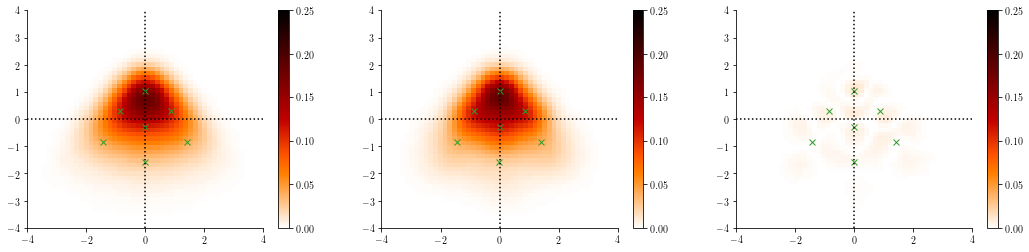

In [55]:
vmin,vmax = 0.0,0.25
c_x = get_cmap('tab10')(2)
cm = get_cmap('gist_heat_r')

plt.figure(figsize=(18,4))

## planted data
plt.subplot(131)
plt.imshow(arr_rho,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin,vmax=vmax,cmap=cm)
plt.colorbar()

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    plt.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
plt.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
plt.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)

## data generated from fitted gmm
plt.subplot(132)
## plot sampled data with cluster centers
plt.imshow(arr_rho_gmm,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin,vmax=vmax,cmap=cm)
plt.colorbar()

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    plt.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
plt.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
plt.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)

## difference
plt.subplot(133)
## plot sampled data with cluster centers
cm = get_cmap('gist_heat_r')

vmin_d = vmin
vmax_d = vmax
arr_rho_diff = np.abs(arr_rho_gmm-arr_rho)
x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    plt.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
plt.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
plt.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)

plt.imshow(arr_rho_diff,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin_d,vmax=vmax_d,cmap=cm)
plt.colorbar()

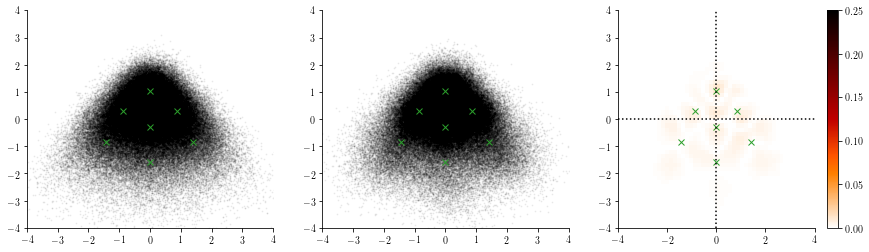

In [71]:
vmin,vmax = 0.0,0.25
c_x = get_cmap('tab10')(2)
c_0 = get_cmap('tab10')(1)
alpha_val = 0.05


plt.figure(figsize=(15,4))

## planted data
plt.subplot(131)
plt.plot(X[:,0],X[:,1],color='black',ms=1,marker='o',lw=0,alpha=alpha_val)

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    plt.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
# plt.plot([-xlim,xlim],[0,0],ls=':',color=c_0,alpha=1.)
# plt.plot([0,0],[-ylim,ylim],ls=':',color=c_0,alpha=1.)

plt.xlim(-xlim,xlim)
plt.ylim(-ylim,ylim)
## data generated from fitted gmm
plt.subplot(132)
## plot sampled data with cluster centers
plt.plot(X_gmm[:,0],X_gmm[:,1],color='black',ms=1,marker='o',lw=0,alpha=alpha_val)


x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    plt.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
# plt.plot([-xlim,xlim],[0,0],ls=':',color=c_0,alpha=1.)
# plt.plot([0,0],[-ylim,ylim],ls=':',color=c_0,alpha=1.)

plt.xlim(-xlim,xlim)
plt.ylim(-ylim,ylim)

## difference
plt.subplot(133)
## plot sampled data with cluster centers
cm = get_cmap('gist_heat_r')

vmin_d = vmin
vmax_d = vmax
arr_rho_diff = np.abs(arr_rho_gmm-arr_rho)
x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    plt.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
plt.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
plt.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)

plt.imshow(arr_rho_diff,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin_d,vmax=vmax_d,cmap=cm)
plt.colorbar()

## Make the proper plot

In [120]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 510  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/2.# Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
Ampl = 1.0 # Amplification factor for screen: set this to ONE for final plot of eps
fig_size = [Ampl*fig_width,Ampl*fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'backend': 'ps',
          'axes.labelsize': Ampl*10,
#           'text.fontsize': Ampl*10,
          'legend.fontsize': Ampl*6,
          'xtick.labelsize': Ampl*10,
          'ytick.labelsize': Ampl*10,
          'text.usetex': True,
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          #'figtext.fontsize': Ampl*10,
          'text.latex.unicode':True,
          'text.latex.preamble': [r'\usepackage{bm}'],
          'xtick.direction':'out',
          'ytick.direction':'out',
          
          'axes.spines.right' : False,
          'axes.spines.top' : False

         }
plt.rcParams.update(params)

/home/martin/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

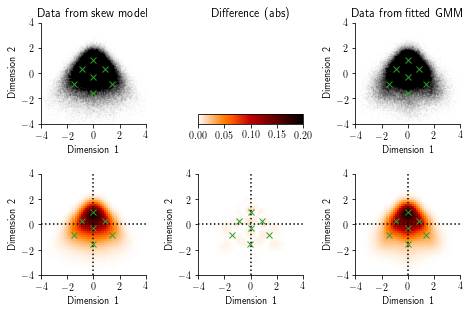

In [130]:
vmin,vmax = 0.0,0.2
vmin_d,vmax_d = vmin,vmax
c_x = get_cmap('tab10')(2)
cm = get_cmap('gist_heat_r')
alpha_val = 0.01

xlabels = [-4,-2,0,2,4]
ylabels = [-4,-2,0,2,4]

f = plt.figure()
plt.clf()


ax=f.add_subplot(231)
ax.set_title('Data from skew model')
ax.plot(X[:,0],X[:,1],color='black',ms=1,marker='o',lw=0,alpha=alpha_val)

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    ax.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1


ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_xticks(xlabels)
ax.set_yticks(ylabels)

ax=f.add_subplot(233)
ax.set_title('Data from fitted GMM')

ax.plot(X_gmm[:,0],X_gmm[:,1],color='black',ms=1,marker='o',lw=0,alpha=alpha_val)

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    ax.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1


ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_xticks(xlabels)
ax.set_yticks(ylabels)

ax = f.add_subplot(234)

im = ax.imshow(arr_rho,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin,vmax=vmax,cmap=cm)

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    ax.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
ax.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
ax.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)

ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_xticks(xlabels)
ax.set_yticks(ylabels)

ax = f.add_subplot(236)

im = ax.imshow(arr_rho_gmm,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin,vmax=vmax,cmap=cm)

x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    ax.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
ax.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
ax.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)


ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_xticks(xlabels)
ax.set_yticks(ylabels)


ax = f.add_subplot(232)
ax.set_title('Difference (abs)')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_axis_off()

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="10%", pad=0, pack_start=True)
f.add_axes(cax)
f.colorbar(im, cax=cax, orientation="horizontal",ticks=[0.0,0.05,0.1,0.15,0.2])




ax = f.add_subplot(235)
arr_rho_diff = np.abs(arr_rho_gmm-arr_rho)

im = ax.imshow(arr_rho_diff,origin='lower',extent=(-xlim,xlim,-ylim,ylim),aspect='auto',vmin=vmin_d,vmax=vmax_d,cmap=cm)






x_mu = gmm.means_
i_x_mu_tmp=0
for  x_mu_tmp in x_mu:
    marker= 'x'
    ax.plot(x_mu_tmp[0],x_mu_tmp[1],lw=0,marker=marker,color=c_x)
    i_x_mu_tmp +=1
ax.plot([-xlim,xlim],[0,0],ls=':',color='black',alpha=1.)
ax.plot([0,0],[-ylim,ylim],ls=':',color='black',alpha=1.)

ax.set_xlim(-xlim,xlim)
ax.set_ylim(-ylim,ylim)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_xticks(xlabels)
ax.set_yticks(ylabels)

plt.subplots_adjust(bottom=0.15,wspace=0.5,hspace=0.5,left=0.15)

path_save = '../figures/'
fname_save = 'commentary-katahira_distinguish-synth-gmm.png'
filename = os.path.join(path_save,fname_save)
plt.savefig(filename,dpi=300)

In [131]:
vmax

0.2

## How good is the fit?

- test-statistic: likelihood (for now)
- draw many synthetic dataset

In [20]:
## the neg-likelihood of the gmm on the 'real' data [smaller is better]
L = -gmm.score(X)
L

2.7191029775332556

In [28]:
## draw many syntehtic gmm-datasets and record how good the fit is.
n_rep_gof = 1000
list_L_gmm = []
for i_nrep_gof in range(n_rep_gof):
    if i_nrep_gof%100==0:
        print(i_nrep_gof)
    ## draw a synthetic dataset from fitted gmm
    X_gmm_tmp,labels_gmm_tmp = gmm.sample(n_samples=N)
    ## fit the gmm-data to a gmm
    gmm_synth = GaussianMixture(Nc,n_init=1)
    gmm_synth.fit(X_gmm_tmp)
    ## get the neg-log-likelihood of the fit
    L_gmm_tmp = gmm_synth.score(X_gmm_tmp)
    list_L_gmm += [-L_gmm_tmp]

    ## fit this data to the gmm

0
100
200
300
400
500
600
700
800
900


In [42]:
L_gmm_mu = np.mean(list_L_gmm)
L_gmm_std = np.std(list_L_gmm)
L_z = (L-L_gmm_mu)/L_gmm_std
print(L_z)
## number of standard deviations the empoirical result is away from syntehtic

2.120517356870303


In [43]:
np.sum(L<list_L_gmm)/n_rep_gof 
## this corresponds to the p-value of the fit!

0.012

## Summary

We compared the cases:

- the skew-data as constructed from Katahira et al 
- the gaussian mixture model with 7 clusters


Findings:

1. The two distributions look very similar.
2. Given the skew-data, we cannot reject the hypothesis that the data was generated by a GMM with 7 clusters
